In [1]:
from IPython.display import HTML
style = "<style>.rendered_html tr,.rendered_html td {font-size: 12pt !important;}</style>"
HTML(style)

# Outline
1. Tensorflow 
2. Keras
3. Data Input Pipelines
4. Training and saving models
5. TensorBoard
6. Distributed training

# Tensorflow
A machine learning library created by Google

In [1]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.0.0'

   Computations in Tensorflow involve tensors and operations:
   - **Tensor**: A description of a multidimensional array. The main object passed in a tensorFlow program is tf.Tensor. 
         A tf.Tensor has the following properties:
            - A data type (float32, int32, or string, for example)
            - A shape
   - **Operation**:  An operation can have zero or more inputs and produce zero or more outputs. As such, an operation may represent a mathematical equation, variable, constant, or a control flow directive.

In [4]:
#tensor that holds a variable
#A variable is defined by its name, type, shape, and initialization procedure.
cool_numbers  = tf.Variable([3.14159, 2.71828], tf.float32)
print('Tensor:',cool_numbers,'\n')
print('data type :',cool_numbers.dtype)
print('shape:',cool_numbers.shape)

Tensor: <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([3.14159, 2.71828], dtype=float32)> 

data type : <dtype: 'float32'>
shape: (2,)


In [5]:
#Tensor that holds a constant
d = tf.constant([1.0, 1.0])
#we can get a numpy array out of a tensor
print(d.numpy())

[1. 1.]


In [6]:
#operations in tensorflow consume and produce tensors
e=tf.add(d,cool_numbers)
print(e)

tf.Tensor([4.14159 3.71828], shape=(2,), dtype=float32)


## Computational Graphs
* Most DL frameworks are based on the idea of computational graphs.
* A computational graph is a type of *directed graph* where nodes describe **operations**, while edges represent the data (**tensor**) flowing between those operations. <br>
**Advantages of computational graphs**:
- **Dependency driven scheduling**: data dependencies, which specify the order of execution. Operations that do not depend on one another can be scheduled in parallel.
- **Graph Optimizations**: Such as common subgraph elimination
- **Automatic Differentiation**: allows us to calculate derivatives automatically by moving backwards along the graph. Each node computes the gradient of its outputs with respect to each input. Using chain rule, we can compute the derivative of any tensor with respect to any other Tensor => Useful for implementing Backpropagation.

## Eager Execution
- An imperative programming environment that **evaluates operations immediately, without building graphs**: operations return concrete values instead of constructing a computational graph to run later.
- Tensorflow2.0 uses eager execution by default.
- tf.Tensor objects are concrete objects

In [7]:
import numpy as np
np.random.seed(0)
data = np.random.randn(3, 2)
#define Keras Layers
def simpler_nn_layer(x,units):
    w=tf.Variable(np.random.randn(x.shape[-1],units))
    b=tf.Variable(np.random.randn(units,))
    return tf.nn.relu(tf.add(tf.matmul(x,w),b))

In [8]:
def model_1(data):
    x=simpler_nn_layer(data,4)
    print('After the first layer:\n', x.numpy())
    x=simpler_nn_layer(x,5)
    print('After the second layer:\n', x.numpy())
    out=simpler_nn_layer(x,2)
    return out
print('Model\'s output:\n', model_1(data).numpy())

After the first layer:
 [[2.17750901 0.64861032 1.61653035 0.56784812]
 [1.69653711 3.44440689 3.09845912 0.4693708 ]
 [2.07743785 0.         0.55756655 0.44274795]]
After the second layer:
 [[ 1.1659976   1.48778413  0.          1.34285133  0.        ]
 [ 1.40701156 10.45609888  0.          1.59566486  0.        ]
 [ 0.24068472  0.          0.          0.69339352  0.12689387]]
Model's output:
 [[0.15652868 0.        ]
 [0.         0.        ]
 [0.         0.        ]]


- Automatic Differentiation is not as obvious in eager mode, since there is no graph to trace operations, and hence compute gradients => use **tf.GradientTape** to train and/or compute gradients in eager.
- Since different operations can occur during each call, all forward-pass operations get recorded to a "tape". 
- To compute the gradient, play the tape backwards and then discard. 
- A particular tf.GradientTape can only compute one gradient; subsequent calls throw a runtime error.

**tf.GradientTape**:
+ Record operations for automatic differentiation.
+ Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched".
+ Computes vector-Jacobian products ("VJP"s) using reverse-mode autodiff (backprop)

In [9]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
    g.watch(x)
    y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


- Eager execution makes development and debugging more interactive.
- But graph execution has advantages for distributed training, performance optimizations, and production deployment.
=> Tensorflow 2.x offers a bridge between Eager mode and graph mode via the AutoGraph(tf.function) API.

## Autograph mode
- AutoGraph brings together the ease of Eager execution and the power of Graphs.
- In short, AutoGraph is a mini-compiler that transpiles a subset of Python syntax into portable, high-performance TensorFlow graphs.
- Using tf.function decorator, transform a subset of Python syntax into TensorFlow graphs.
- tf.Tensor objects are symbolic handles to nodes in a computational graph => we cannot see intermediate states of the model or add any nodes on the fly.

In [10]:
W = tf.Variable(tf.ones(shape=(2,2)), name="W")
b = tf.Variable(tf.zeros(shape=(2)), name="b")
#Creates a callable TensorFlow graph from a Python function
@tf.function
def forward(x):
    print('building the graph\n')
    z1=W*x
    print('linear mapping:\n', z1)
    z2=z1+b
    print('affine mapping:\n',z2)
    a=tf.nn.relu(z2)
    print('activation:\n',z2)
    return a

In [11]:
#we can have access to the calculated value only after evaluation.
out_a=forward([1,0])
print('Evaluating the graph on data \n output:\n',out_a)

building the graph

linear mapping:
 Tensor("mul:0", shape=(2, 2), dtype=float32)
affine mapping:
 Tensor("add:0", shape=(2, 2), dtype=float32)
activation:
 Tensor("add:0", shape=(2, 2), dtype=float32)
Evaluating the graph on data 
 output:
 tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


Advantages:
- faster execution: Allows the TensorFlow runtime to apply optimizations and exploit parallelism in the computation defined by the function
- running on GPU or TPU
- exporting to SavedModel

# Keras
- A high-level API to build and train models that includes first-class support for TensorFlow-specific functionality 
- Implementation schemes: 
    - Sequential
    - Functional
    - Subclassed

## The Layer Class

- tf.keras.layers.Layer is the class from which all layers inherit.
- A layer is a class implementing common neural networks operations, such as convolution, batch norm, etc. These operations require **managing weights, losses, updates, and inter-layer connectivity.**
- For subclassing the Layer class, follow the general pattern:
    - \__init__: Collect layer parameters
    - build : Create the variables using add_weight method, which allows allows Keras to track variables and regularization losses
    - call : Define the calculation for the forward pass

In [5]:
class Linear(tf.keras.layers.Layer):
    def __init__(self,units=32, **kwargs):
        #super(Linear,self) is equivalent to parameterless super() call
        super(Linear, self).__init__(**kwargs)
        self.units=units
          
    def build(self,input_shape):
        #lazy creation of weights when size is known
        self.w=self.add_weight(shape=(input_shape[-1],self.units), 
                               #input_shape is a property of the Layer class, retrievs the input's shape when layer has only one input
                              dtype=tf.float32,
                              initializer=tf.keras.initializers.ones(),
                              regularizer=tf.keras.regularizers.l2(0.02),
                                #trainable parameter decides if the weights are taken into account during backpropagation
                              trainable=True)
        self.b=self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)
    #The call method will automatically run build the first time it is called.
    @tf.function   
    def call(self,inputs):
        return tf.matmul(inputs, self.w)+self.b
     

In [7]:
x=tf.ones((2,2))
linear_layer=Linear(32)
#evaluate layer's output
y=linear_layer(x)

In [14]:
#get the weights, method returns an array
weights=linear_layer.get_weights()
#returns a list of all layer variables (alias for weights)
variables=linear_layer.variables
print(variables)

[<tf.Variable 'linear/Variable:0' shape=(2, 32) dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
      dtype=float32)>, <tf.Variable 'linear/Variable:0' shape=(32,) dtype=float32, numpy=
array([ 0.04390056,  0.00180454, -0.01661463,  0.01921361, -0.03416645,
        0.00720847,  0.00565528, -0.00904692,  0.01670395, -0.10099991,
       -0.07016704, -0.02862871, -0.03424366,  0.0092374 , -0.0108764 ,
        0.01634361,  0.00054799,  0.05380085,  0.00140211,  0.05664849,
        0.03822742,  0.0432707 ,  0.02787811, -0.13538454,  0.03400497,
        0.00694666, -0.01874007, -0.04829953,  0.01036013,  0.01462585,
       -0.01268575, -0.00070864], dtype=float32)>]


## The Model class
- Groups layers into an object with training and inference features.
- The Model class has the same API as Layer, with the following differences:

    * It exposes built-in training, evaluation, and prediction loops (model.fit(), model.evaluate(), model.predict()).
    * It exposes the list of its inner layers, via the model.layers property.
    * It exposes saving and serialization APIs.


In [19]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
        self.dropout = tf.keras.layers.Dropout(0.5)
    def call(self, inputs,training= False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x, training=training)
        return self.dense2(x)

In [17]:
keras_model=MyModel()

In [18]:
keras_model.layers

## The Sequential Class
Linear stack of layers.
Takes as argument a list of layers to add to the model.

In [53]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [17]:
train_data = tf.ones(shape=(1, 28, 28, 1))
test_data = tf.ones(shape=(1, 28, 28, 1))
# The training argument is passed to each layer by the model when it runs.
train_out = model_CNN(train_data, training=True)
print(train_out)

tf.Tensor([[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]], shape=(1, 10), dtype=float32)


In [22]:
#while testing, set parameter training=False
test_out = model_CNN(test_data, training=False)
print(test_out)

tf.Tensor(
[[0.11332399 0.08523628 0.08153324 0.07600356 0.09525321 0.14654912
  0.1167627  0.09377945 0.07928437 0.11227413]], shape=(1, 10), dtype=float32)


In [19]:
#number of trainable variables
len(model_CNN.trainable_variables)

8

In [20]:
#regularization loss.
model_CNN.losses

[<tf.Tensor: id=479, shape=(), dtype=float32, numpy=0.07901106>]

 tf.keras uses graph execution by default. To enable eager mode set parameter run_eagerly=True when you compile the model.

# Data input pipeline
## tf.data
Read, handle and transform data. There are two distinct ways to create a dataset:
- A data **source** constructs a Dataset from data stored in memory or in one or more files.
- A data **transformation** constructs a dataset from one or more tf.data.Dataset objects.

Reading Input:
- to construct a Dataset from data **in memory**, you can use tf.data.Dataset.from_tensors() or tf.data.Dataset.from_tensor_slices(). 
- Alternatively, if your input data is stored in a file in the recommended **TFRecord format**, you can use tf.data.TFRecordDataset().

### numpy Data

In [21]:
import numpy as np
np.random.seed(0)
data = np.random.randn(256, 8, 8, 3)
#Create a Dataset whose elements are slices of the given tensors.
#The given tensors are sliced along their first dimension: dataset dimension
dataset = tf.data.Dataset.from_tensor_slices(data)
print(dataset)

<TensorSliceDataset shapes: (8, 8, 3), types: tf.float64>


- By convention, the first dimension is the number of training examples, default is set to 1 data example.
- The dataset is an iterator now and can be itarated with a for-loop.

In [22]:
for i, batch in enumerate(dataset):
    if i == 255 or i == 256:
        print(i, batch.shape)

255 (8, 8, 3)


In [23]:
#take a desired number of batches
for batch in dataset.take(3):
    print(batch.shape)

(8, 8, 3)
(8, 8, 3)
(8, 8, 3)


In [24]:
#specify a different batch size 
dataset = dataset.batch(16)
for batch in dataset.take(3):
    print(batch.shape)

(16, 8, 8, 3)
(16, 8, 8, 3)
(16, 8, 8, 3)


### pandas Dataframe.

In [25]:
#reading with pandas
import pandas as pd
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')

In [26]:
df = pd.read_csv(csv_file)
df.head(2)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   

   ca    thal  target  
0   0   fixed       0  
1   3  normal       1

In [27]:
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes
df.head(2)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   

   ca  thal  target  
0   0     2       0  
1   3     3       1

In [28]:
# loading data using tf.data.Dataset
target = df.pop('target')
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))
for feat, targ in dataset.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ], Target: 0
Features: [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
   3. ], Target: 0
Features: [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
   3. ], Target: 0


### Shuffling
- tf.data.Dataset.shuffle(buffer_size) 
- Randomly shuffles the elements of this dataset. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

In [29]:
#before shuffling
dataset = tf.data.Dataset.from_tensor_slices(np.arange(19))
for batch in dataset.batch(5):
    print(batch)

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int32)
tf.Tensor([10 11 12 13 14], shape=(5,), dtype=int32)
tf.Tensor([15 16 17 18], shape=(4,), dtype=int32)


In [30]:
#after shuffling
buffer_size=5
for batch in dataset.shuffle(buffer_size).batch(5):
    print(batch)

tf.Tensor([2 4 5 3 6], shape=(5,), dtype=int32)
tf.Tensor([ 1 10  0  9  8], shape=(5,), dtype=int32)
tf.Tensor([14 11 13  7 16], shape=(5,), dtype=int32)
tf.Tensor([18 17 12 15], shape=(4,), dtype=int32)


### Preprocessing
Transfrom data while reading using  tf.data.Dataset.map(map_func): 
- applies map_func to each element of this dataset
- returns a new dataset containing the transformed elements, in the same order as they appeared in the input.

In [31]:
def tranform(data):
    mean = tf.reduce_mean(data)
    return data - mean
#here transform is applied to each batch
for batch in dataset.shuffle(5).batch(5).map(tranform):
    print(batch)

tf.Tensor([ 0 -2  1 -1  2], shape=(5,), dtype=int32)
tf.Tensor([ 0  3 -1 -2  1], shape=(5,), dtype=int32)
tf.Tensor([-1  2 -3  4  1], shape=(5,), dtype=int32)
tf.Tensor([ 2  0 -3  3], shape=(4,), dtype=int32)


### Time-Series windowing
https://www.tensorflow.org/guide/data#time_series_windowing

### Example
Using predefined datasets

In [28]:
#using predefined data set as tf.data.Dataset object
import tensorflow_datasets as tfds

datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)
mnist_train, mnist_test = datasets['train'], datasets['test']
BUFFER_SIZE = 10 # Use a much larger value for real code.
BATCH_SIZE = 64
NUM_EPOCHS = 5
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label
train_data = mnist_train.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_data = mnist_test.map(scale).batch(BATCH_SIZE)
STEPS_PER_EPOCH = 5
train_data = train_data.take(STEPS_PER_EPOCH)
test_data = test_data.take(STEPS_PER_EPOCH)
print(train_data)
image_batch, label_batch = next(iter(train_data))

<TakeDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


## Optimize performance
https://www.tensorflow.org/guide/data_performance#overview

# Training and saving models
## Keras
Use Keras's built-in fit, evaluate, and predict:
   * They accept Numpy arrays, Python generators and, tf.data.Datasets
   * They apply regularization, and activation losses automatically.
   * They support tf.distribute for multi-device training.
   * They support arbitrary callables as losses and metrics.
   * They support callbacks like tf.keras.callbacks.TensorBoard, and custom callbacks.
   * They are performant, automatically using TensorFlow graphs.

In [29]:
#Configure the model for training
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
#Train the model for a fixed number of epochs (iterations on a dataset).
#here the MNIST training data from the previous example are taken
model_CNN.fit(train_data, epochs=NUM_EPOCHS)

Epoch 1/5
5/5 [==============================] - 1s 297ms/step - loss: 1.6924 - accuracy: 0.4656
Epoch 2/5
5/5 [==============================] - 0s 49ms/step - loss: 0.6792 - accuracy: 0.8531
Epoch 3/5
5/5 [==============================] - 0s 46ms/step - loss: 0.4781 - accuracy: 0.9000
Epoch 4/5
5/5 [==============================] - 0s 47ms/step - loss: 0.3702 - accuracy: 0.9469
Epoch 5/5
5/5 [==============================] - 0s 47ms/step - loss: 0.2994 - accuracy: 0.9719


In [31]:
#Return the loss value & metrics values for the model in test mode, computation in batches
loss, acc = model_CNN.evaluate(test_data)
print("Loss {}, Accuracy {}".format(loss, acc))

5/5 [==============================] - 0s 44ms/step - loss: 1.7089 - accuracy: 0.6406
Loss 1.7089128732681274, Accuracy 0.640625


In [34]:
#Generate output predictions for the input samples
image_batch_test, label_batch_test = next(iter(test_data))
#predictions are a probab. dist. over classes
predictions=model_CNN.predict(image_batch_test)
#Generate class predictions for the input samples.
class_predictions=model_CNN.predict_classes(image_batch_test)
print('Classes predicted by model:\n',class_predictions)
print('True class labels:\n',label_batch_test)

Classes predicted by model:
 [6 8 8 7 7 2 3 4 7 6 6 8 2 8 9 6 8 0 6 8 8 4 8 8 9 8 9 6 8 5 8 8 3 1 3 3 8
 8 7 6 8 8 3 3 6 1 8 8 8 0 8 7 7 0 8 5 1 3 8 0 0 7 8 1]
True class labels:
 tf.Tensor(
[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5 1 4 8 1 9 8 4 0 0 5 2 4 2 1 3 2 8
 1 7 6 8 2 3 3 6 1 0 4 1 0 9 7 7 0 0 5 1 3 5 0 0 7 5 1], shape=(64,), dtype=int64)


**Saving**
- The save method saves the model to Tensorflow SavedModel (the universal serialization format for TensorFlow models) or a single HDF5 file.
- The savefile includes:
    * The model architecture, allowing to re-instantiate the model.
    * The model weights.
    * The state of the optimizer, allowing to resume training exactly where you left off.

In [35]:
model_CNN.save('model_CNN.h5')  # creates a HDF5 file 'model_CNN.h5'
del model_CNN  # deletes the existing model

# returns a compiled model identical to the previous one
# unless the saved model was never compiled in the first place
loaded_model = tf.keras.models.load_model('model_CNN.h5')

## tf.GradientTape
Custom training steps:
1. Iterate over a Python generator or tf.data.Dataset to get batches of examples.
2. Use tf.GradientTape to collect gradients.
3. Use one of the tf.keras.optimizers to apply weight updates to the model's variables, or do it manually.

In [36]:
class Net(tf.keras.Model):
    #A simple linear model
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = tf.keras.layers.Dense(5)
    @tf.function
    def call(self, x):
        return self.l1(x)

In [37]:
def toy_dataset():
    inputs = tf.range(10.)[:, None]
    labels = inputs * 5. + tf.range(5.)[None, :]
    return tf.data.Dataset.from_tensor_slices(dict(x=inputs, y=labels)).repeat(10).batch(2)

In [38]:
@tf.function
#trains the net on example using optimizer 
def train_step(net, example, optimizer):
    with tf.GradientTape() as tape:
        output = net(example['x'])
        loss = tf.reduce_mean(tf.abs(output - example['y']))
        #trainable variables are automatically watched
        variables = net.trainable_variables
    #Compute the gradient using operations recorded in context of this tape.    
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

**Custom saving and loading**:
The phrase "Saving a TensorFlow model" typically means one of two things:
1. Checkpoints, OR
2. SavedModel.

**Manual Checkpointing**:
Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model. Checkpoints do not contain any description of the computation defined by the model and thus are typically only useful when source code that will use the saved parameter values is available.
- Need a **tf.train.Checkpoint** object where the objects you want to checkpoint are set as attributes on the object.
    + Checkpoint's constructor accepts keyword arguments whose values are types that contain trackable state, such as tf.keras.optimizers.Optimizer, tf.Variable, tf.keras.Layer, or tf.keras.Model implementations. It saves these values with a checkpoint, and maintains a save_counter for numbering checkpoints.
    + **Checkpoint.save** and **Checkpoint.restore** write and read object-based checkpoints. Object-based checkpointing saves a graph of dependencies between Python objects (Layers, Optimizers, Variables, etc.) with named edges, and this graph is used to match variables when restoring a checkpoint.
- A **tf.train.CheckpointManager** can also be helpful for managing multiple checkpoints.

In [39]:
#create instances of the net and optimizer
net=Net()
opt = tf.keras.optimizers.Adam(0.1)
#define a checkpoint object, as arguments the objects we want to track
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net)
#define a checkpoint manager, it normally deletes old checkpoints, configure to leave the last 3 checkpoints
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

**Training loop** : 
- call the training step in a loop on each batch of data
- periodically writes checkpoints to disk

In [40]:
def train_and_checkpoint(net, manager):
    #restore the latest checkpoint
    ckpt.restore(manager.latest_checkpoint)
    #if a checkpoint already exists
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    #if no checkpoints exist
    else:
        print("Initializing from scratch.")

    for example in toy_dataset():
        loss = train_step(net, example, opt)
        #increment the training step
        ckpt.step.assign_add(1)
        #save checkpoint each 10 steps
        if int(ckpt.step) % 10 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            print("loss {:1.2f}".format(loss.numpy()))

In [41]:
train_and_checkpoint(net, manager)

Initializing from scratch.
Saved checkpoint for step 10: ./tf_ckpts\ckpt-1
loss 31.64
Saved checkpoint for step 20: ./tf_ckpts\ckpt-2
loss 25.05
Saved checkpoint for step 30: ./tf_ckpts\ckpt-3
loss 18.49
Saved checkpoint for step 40: ./tf_ckpts\ckpt-4
loss 11.99
Saved checkpoint for step 50: ./tf_ckpts\ckpt-5
loss 5.71


In [42]:
#a single checkpoint file ('./tf_ckpts/checkpoint') where the CheckpointManager saves its state.
!ls ./tf_ckpts

checkpoint
ckpt-3.data-00000-of-00001
ckpt-3.index
ckpt-4.data-00000-of-00001
ckpt-4.index
ckpt-5.data-00000-of-00001
ckpt-5.index


**Manually inspecting checkpoints**
- tf.train.list_variables lists the checkpoint keys and shapes of variables in a checkpoint.
- Checkpoint keys are paths in the graph

In [43]:
tf.train.list_variables(tf.train.latest_checkpoint('./tf_ckpts/'))

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('net/l1/bias/.ATTRIBUTES/VARIABLE_VALUE', [5]),
 ('net/l1/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', [5]),
 ('net/l1/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', [5]),
 ('net/l1/kernel/.ATTRIBUTES/VARIABLE_VALUE', [1, 5]),
 ('net/l1/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [1, 5]),
 ('net/l1/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [1, 5]),
 ('optimizer/beta_1/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('optimizer/beta_2/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('optimizer/decay/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('optimizer/iter/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('optimizer/learning_rate/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('save_counter/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('step/.ATTRIBUTES/VARIABLE_VALUE', [])]

In [44]:
print(net.l1.bias.numpy())
print(opt.beta_1.numpy())

[4.272422  4.46587   4.551586  4.7641597 4.9637203]
0.9


# Tensor Board 
- TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. 
- It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.
    * The Scalars dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.
    * The Graphs dashboard helps you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly. 
    * The Distributions and Histograms dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.

In [55]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Keras
- While fitting the model add the tf.keras.callback.TensorBoard callback to that logs are created and stored. Additionally, enable histogram computation every epoch with histogram_freq=1 (off by default)

In [54]:
import datetime
import os

In [56]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [57]:
#Place the logs in a timestamped subdirectory to allow easy selection of different training runs
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#create a tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#add the callback while fitting
model_CNN.fit(train_data, 
          epochs=NUM_EPOCHS, 
          callbacks=[tensorboard_callback])

Epoch 1/5
5/5 [==============================] - 2s 372ms/step - loss: 1.8867 - accuracy: 0.4250
Epoch 2/5
5/5 [==============================] - 1s 123ms/step - loss: 0.7270 - accuracy: 0.8281
Epoch 3/5
5/5 [==============================] - 1s 133ms/step - loss: 0.4977 - accuracy: 0.9031
Epoch 4/5
5/5 [==============================] - 0s 94ms/step - loss: 0.4003 - accuracy: 0.9469
Epoch 5/5
5/5 [==============================] - 1s 105ms/step - loss: 0.3052 - accuracy: 0.9719


In [58]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 43204), started 1 day, 19:30:13 ago. (Use '!kill 43204' to kill it.)

# Distributed training

In [52]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


**Data paralellism**:
- We use multiple GPUs to run the same TensorFlow code. 
- Each GPU is feed with different batch of data.

## Manual device placement

In [3]:
# To find out which devices your operations and tensors are assigned to
tf.debugging.set_log_device_placement(True)

gpus = tf.config.experimental.list_logical_devices('GPU')
if gpus:
  # Replicate your computation on multiple GPUs
    c = []
    for gpu in gpus:
        #with tf.device to create a device context, 
        #and all the operations within that context will run on the same designated device.
        with tf.device(gpu.name):
            a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
            b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
            c.append(tf.matmul(a, b))

    with tf.device('/CPU:0'):
        matmul_sum = tf.add_n(c)
    print(matmul_sum)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0 <br>
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:1 <br>
Executing op AddN in device /job:localhost/replica:0/task:0/device:CPU:0 <br>
tf.Tensor(
[[ 44.  56.]
 [ 98. 128.]], shape=(2, 2), dtype=float32)

## tf.distribute.Strategy
TensorFlow API to distribute training across multiple GPUs, multiple machines or TPUs.
Types of strategies:
- MirroredStrategy
- CentralStorageStrategy
- MultiWorkerMirroredStrategy
- TPUStrategy
- ParameterServerStrategy
- OneDeviceStrategy

### tf.distribute.MirroredStrategy
- supports **synchronous** distributed training on **multiple GPUs on one machine.**
- creates **one replica per GPU device.**
- Each variable in the model is mirrored across all the replicas. Together, these variables form a single conceptual variable called **MirroredVariable**. These variables are kept in sync with each other by applying identical updates.
- Efficient **all-reduce algorithms** are used to communicate the variable updates across the devices. All-reduce aggregates tensors across all the devices by adding them up, and makes them available on each device.

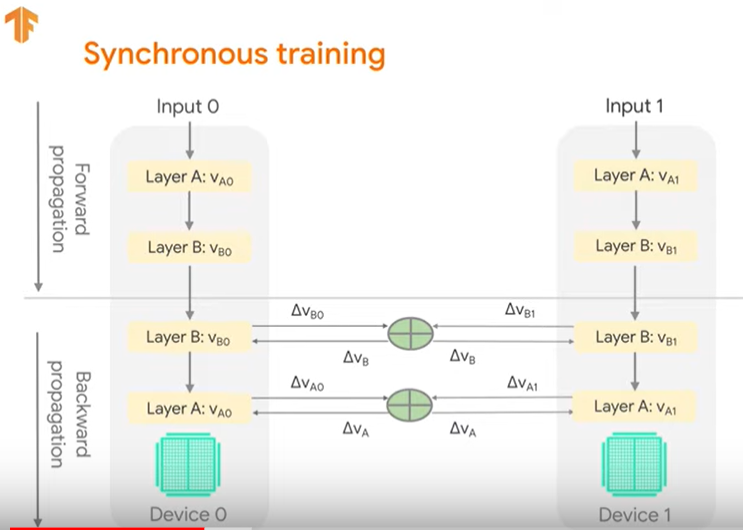

In [5]:
from IPython.display import display, Image
i = Image(filename='Neuer Ordner/sync_training.png')
display(i)

MirroredStrategy takes care of replicating the model's training on the available GPUs, aggregating gradients, and more.

In [6]:
tf.debugging.set_log_device_placement(True)

strategy = tf.distribute.MirroredStrategy()
# scope indicates which part of the code to distribute
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(1,))
    predictions = tf.keras.layers.Dense(1)(inputs)
    #creating the model under the scope allows to create mirrored variables instead of regular variables
    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    #compiling under the scope indicates we want to train under this strategy
    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0


- Each batch of the given input is divided equally among the multiple replicas.
- For instance, if using MirroredStrategy with 2 GPUs, each batch of size 10 will get divided among the 2 GPUs, with each receiving 5 input examples in each step.

In [7]:
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(10)
model.fit(dataset, epochs=2)
model.evaluate(dataset)

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/2
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /

0.0

# References
https://medium.com/ai%C2%B3-theory-practice-business/tensorflow-1-0-vs-2-0-part-1-computational-graphs-4bb6e31c1a0f <br>
https://medium.com/@lsgrep/tensorflow-1-0-vs-2-0-part-2-eager-execution-and-autograph-47473ed8b817